In [5]:
%reload_ext autoreload
%autoreload 2


In [6]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'DEBUG',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
## Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

#!pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygraphviz

### Step-1. Create a Causal Graph

In [7]:
df = pd.read_csv('loans_causal_schema.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   emp_length                     9183 non-null   float64
 1   state                          10000 non-null  object 
 2   homeownership                  10000 non-null  object 
 3   annual_income                  10000 non-null  float64
 4   debt_to_income                 9976 non-null   float64
 5   delinq_2y                      10000 non-null  int64  
 6   earliest_credit_line           10000 non-null  int64  
 7   inquiries_last_12m             10000 non-null  int64  
 8   total_credit_lines             10000 non-null  int64  
 9   open_credit_lines              10000 non-null  int64  
 10  total_credit_limit             10000 non-null  int64  
 11  total_credit_utilized          10000 non-null  int64  
 12  total_collection_amount_ever   10000 non-null  

In [8]:
#remove unneccessary fields
df.drop(['open_credit_lines', 'total_credit_lines', 
         'total_credit_utilized', 'total_credit_limit',
         'num_accounts_120d_past_due','num_accounts_30d_past_due',
         'num_open_cc_accounts','num_total_cc_accounts',
         ], axis=1, inplace=True)

df.drop(['account_never_delinq_percent','delinq_2y','earliest_credit_line','total_collection_amount_ever',
         'accounts_opened_24m','public_record_bankrupt','num_accounts_past_due','inquiries_last_12m'], axis=1, inplace=True)
df.drop(['loan_status','homeownership'], axis=1, inplace=True)

In [9]:
# we have to remove/fix missing values
df['debt_to_income'] = df['debt_to_income'].interpolate()
df['credit_utilization'] = df['credit_utilization'].interpolate()
df  = df.dropna()

### Step-1. Create a Causal Graph


#### In this step we will make assumptions and domain knowledge applied to causal graph
Here are a list of assumptions that have then been translated into a Causal Diagram


* employment length, state, homeownership status and annual income play a major role in deciding the status of the loan

* length of employment and the state where borrower lives will definitley affect the anual income.  

* homeownership status will play a role in how many mortgage accounts a borrower will have

* In real world, credit duration is usually an indication of the employment duration ('emp_length'-->'credit_duration')

* 'has_bankrupt_history' --> 'has_credit_inquiries_last_12m'

* 'debt_limit_exceded', 'has_past_due_accounts', 'has_collection_accounts', 'delinquent_history' --> 'has_bankrupt_history'

* 'has_bankrupt_history', 'delinquent_history' --> 'is_bad_loan'

* 'credit_line_utilization','credit_utilization', 'cc_utilization' --> 'is_bad_loan'

* 'emp_length' --> 'total_debit_limit'

* 'annual_income' --> 'credit_line_utilization','credit_utilization', 'cc_utilization'


'emp_length', 'state', 'homeownership', 'annual_income',
       'debt_to_income', 'num_satisfactory_accounts',
       'num_active_debit_accounts', 'total_debit_limit',
       'num_cc_carrying_balance', 'num_mort_accounts', 'loan_amount', 'term',
       'interest_rate', 'installment', 'balance', 'paid_total',
       'credit_line_utilization_%', 'credit_utilization_%', 'cc_utilization_%',
       'delinquent_history', 'credit_duration',
       'has_credit_inquiries_last_12m', 'has_collection_accounts',
       'has_accounts_opened_24m', 'has_bankrupt_history',
       'has_past_due_accounts', 'debt_limit_exceded', 'is_bad_loan'

In [10]:
file = open("hybrid_employment_length.dot")
causal_graph = file.read().replace("\n", " ")
file.close()

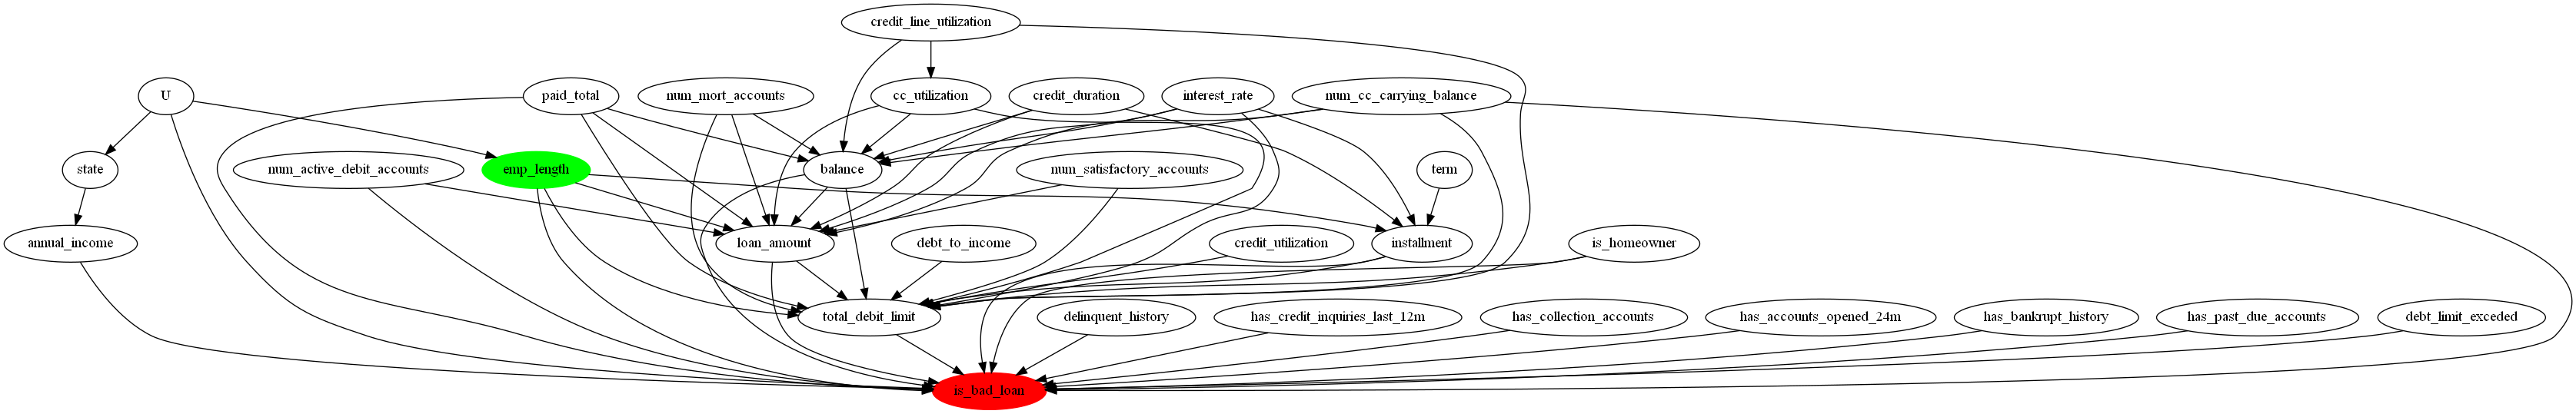

In [11]:
model= dowhy.CausalModel(
        data = df,
        graph='hybrid_employment_length.dot',
        treatment='emp_length',
        outcome='is_bad_loan')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png",width = 5000, height = 100))

In [12]:
model.interpret()

Model to find the causal effect of treatment ['emp_length'] on outcome ['is_bad_loan']


### Step-2. Identify the Causal Effect

In [13]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(is_bad_loan|credit_line_utilization,balance,has_bank
d[emp_length]                                                                 

                                                                              
rupt_history,cc_utilization,num_mort_accounts,has_past_due_accounts,num_satisf
                                                                              

                                                                              
actory_accounts,num_active_debit_accounts,has_accounts_opened_24m,annual_incom
                                                                              

                                                                              
e,is_homeowner,interest_rate,state,credit_duration,term,credit_utilization,deb
                                

### Step-3. Estimate the identified estimand

In [14]:
#'backdoor.propensity_score_stratification','propensity_score_matching','iv.instrumental_variable'
estimates_list = []
methods_list = ['backdoor.linear_regression']
method_param_list = [None] 
for i in range(len(methods_list)):
    print('Estimating--------------->', methods_list[i])
    estimate = model.estimate_effect(identified_estimand,
                                     method_name=methods_list[i],
                                     method_params=method_param_list[i],
                                     target_units="ate",test_significance=True)
    estimates_list.append(estimate)
    print(estimate)

Estimating---------------> backdoor.linear_regression
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(is_bad_loan|credit_line_utilization,balance,has_bank
d[emp_length]                                                                 

                                                                              
rupt_history,cc_utilization,num_mort_accounts,has_past_due_accounts,num_satisf
                                                                              

                                                                              
actory_accounts,num_active_debit_accounts,has_accounts_opened_24m,annual_incom
                                                                              

                                                                              
e,is_home

### Step-4. Refute results

##### Radom Common Cause:
Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.

In [16]:
refuter1=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(refuter1)

Refute: Add a Random Common Cause
Estimated effect:9.706439071145712e-07
New effect:-4.7428959239897983e-07



#### Placebo Treatment Refuter:
Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

In [17]:
refuter2=model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                              placebo_type="permute", num_simulations=5)
print(refuter2)

Refute: Use a Placebo Treatment
Estimated effect:9.706439071145712e-07
New effect:-0.0001622531499079583
p value:0.3459513466487171



#### Data Subset Refuter:
Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

In [18]:
refuter3=model.refute_estimate(identified_estimand, estimate,  method_name="data_subset_refuter")
print(refuter3)

Refute: Use a subset of data
Estimated effect:9.706439071145712e-07
New effect:9.833481838306592e-06
p value:0.45



In [19]:
refuter_list = ["placebo_treatment_refuter","data_subset_refuter", "random_common_cause"]
refutation_list = []
inspect_refutations=True
refuter_count = 1

for refuter in refuter_list:
    refute_estimate = model.refute_estimate(identified_estimand, estimate, method_name=refuter)
    refutation_list.append(refute_estimate)

if inspect_refutations is True:
    for refutation in refutation_list:
        print("####### Refutation {}######################################################".format(refuter_count))
        print("*** Class Name ***")
        print()
        print(refutation.refutation_type)
        print()
        print(refutation)
        print("############################################################################")
        print()
        refuter_count += 1

####### Refutation 1######################################################
*** Class Name ***

Refute: Use a Placebo Treatment

Refute: Use a Placebo Treatment
Estimated effect:9.706439071145712e-07
New effect:-1.8628154574429345e-13
p value:0.0

############################################################################

####### Refutation 2######################################################
*** Class Name ***

Refute: Use a subset of data

Refute: Use a subset of data
Estimated effect:9.706439071145712e-07
New effect:2.2733202830428275e-07
p value:0.43999999999999995

############################################################################

####### Refutation 3######################################################
*** Class Name ***

Refute: Add a Random Common Cause

Refute: Add a Random Common Cause
Estimated effect:9.706439071145712e-07
New effect:1.0589636265968816e-06

############################################################################

